In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd

# Parameters (from problem)
rho = 0.1
A = torch.tensor([[0.0, 1.0], [-2.0, -3.0]])
B = torch.tensor([[0.0], [1.0]])
G = torch.tensor([[0.1, 0.0], [0.0, 0.1]])
Q = torch.eye(2)
R = torch.tensor([[1.0]])

# Neural network for V(x)
class ValueNet(nn.Module):
    def __init__(self, in_dim=2, hidden=64, out_dim=1):
        super(ValueNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, x):
        return self.net(x)

# Instantiate model
model = ValueNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
def pinn_loss(x):
    x.requires_grad_(True)
    V = model(x)

    # Gradient wrt x
    gradV = autograd.grad(V.sum(), x, create_graph=True)[0]  # shape (N,2)

    # Hessian wrt x
    hessV = []
    for i in range(x.shape[1]):
        grad2 = autograd.grad(gradV[:, i].sum(), x, create_graph=True)[0]
        hessV.append(grad2.unsqueeze(1))
    hessV = torch.cat(hessV, dim=1)  # shape (N,2,2)

    # Terms of HJB
    quad_term = torch.sum(x @ Q * x, dim=1, keepdim=True)  # x^T Q x
    Ax = x @ A.T
    grad_term = torch.sum(gradV * Ax, dim=1, keepdim=True)
    control_term = -0.25 * (gradV @ B @ torch.inverse(R) @ B.T @ gradV.unsqueeze(2)).squeeze()
    trace_term = 0.5 * torch.einsum("ij,bji->b", G @ G.T, hessV).unsqueeze(1)

    # HJB residual
    hjb = rho * V - (quad_term + grad_term + control_term + trace_term)
    return (hjb**2).mean()

# Training
for epoch in range(10000):
    x_train = torch.randn(128, 2)  # sample states from normal
    loss = pinn_loss(x_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item():.6f}")

# After training: approximate value function and control
def V_hat(x):
    x_t = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
    return model(x_t).item()

def u_hat(x):
    x_t = torch.tensor(x, dtype=torch.float32).unsqueeze(0).requires_grad_(True)
    V = model(x_t)
    gradV = autograd.grad(V.sum(), x_t, create_graph=False)[0]
    return -(torch.inverse(R) @ B.T @ gradV.T).detach().numpy()


Epoch 0, Loss = 7.465419
Epoch 500, Loss = 0.467749
Epoch 1000, Loss = 0.128960
Epoch 1500, Loss = 0.183165
Epoch 2000, Loss = 0.033609
Epoch 2500, Loss = 0.017457
Epoch 3000, Loss = 0.028422
Epoch 3500, Loss = 0.009926
Epoch 4000, Loss = 0.010974
Epoch 4500, Loss = 0.029239
Epoch 5000, Loss = 0.011562
Epoch 5500, Loss = 0.015962
Epoch 6000, Loss = 0.015847
Epoch 6500, Loss = 0.017673
Epoch 7000, Loss = 0.014316
Epoch 7500, Loss = 0.011364
Epoch 8000, Loss = 0.006625
Epoch 8500, Loss = 0.006730
Epoch 9000, Loss = 0.039414
Epoch 9500, Loss = 0.011652


L1 absolute error (e1): 1.1943612251796984
Relative error (e2): 1.3839484736349892


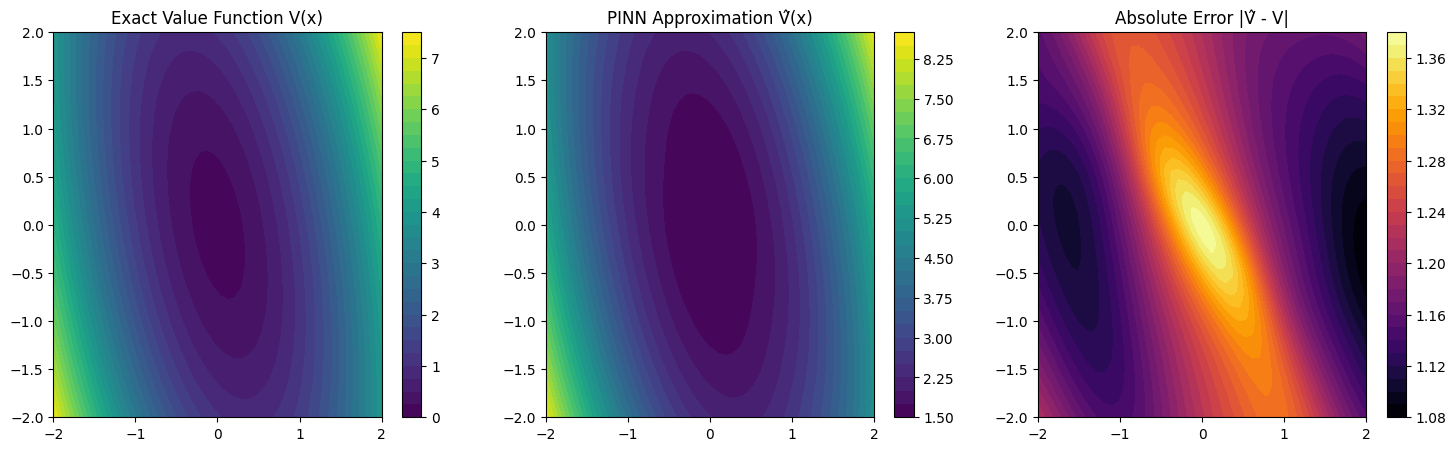

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are

# === Analytical solution ===
# CARE with discount rate
rho = 0.1
A_tilde = A.numpy() - (rho/2) * np.eye(A.shape[0])
P = solve_continuous_are(A_tilde, B.numpy(), Q.numpy(), R.numpy())
c = np.trace(P @ (G.numpy() @ G.numpy().T)) / rho

def V_exact(x):
    return x.T @ P @ x + c

def u_exact(x):
    return -(np.linalg.inv(R.numpy()) @ B.numpy().T @ (P @ x)).flatten()

# === PINN solution ===
def V_hat(x):
    x_t = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
    return model(x_t).item()

def u_hat(x):
    x_t = torch.tensor(x, dtype=torch.float32).unsqueeze(0).requires_grad_(True)
    V = model(x_t)
    gradV = autograd.grad(V.sum(), x_t, create_graph=False)[0]
    return (-(torch.inverse(R) @ B.T @ gradV.T)).detach().numpy().flatten()

# === Evaluation Grid ===
grid_x = np.linspace(-2, 2, 50)
grid_y = np.linspace(-2, 2, 50)
X, Y = np.meshgrid(grid_x, grid_y)

V_exact_vals = np.zeros_like(X)
V_pinn_vals = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x = np.array([X[i, j], Y[i, j]])
        V_exact_vals[i, j] = V_exact(x)
        V_pinn_vals[i, j] = V_hat(x)

# === Error metrics ===
abs_err = np.abs(V_pinn_vals - V_exact_vals)
rel_err = np.abs(V_pinn_vals / V_exact_vals - 1)

e1 = np.mean(abs_err)   # L1 norm (mean absolute error)
e2 = np.mean(rel_err)   # relative error

print("L1 absolute error (e1):", e1)
print("Relative error (e2):", e2)

# === Plots ===
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

cs0 = axs[0].contourf(X, Y, V_exact_vals, levels=30, cmap="viridis")
fig.colorbar(cs0, ax=axs[0])
axs[0].set_title("Exact Value Function V(x)")

cs1 = axs[1].contourf(X, Y, V_pinn_vals, levels=30, cmap="viridis")
fig.colorbar(cs1, ax=axs[1])
axs[1].set_title("PINN Approximation V̂(x)")

cs2 = axs[2].contourf(X, Y, abs_err, levels=30, cmap="inferno")
fig.colorbar(cs2, ax=axs[2])
axs[2].set_title("Absolute Error |V̂ - V|")

plt.show()


L1 absolute error (e1): 2.07573418250468
Relative error (e2): 2.4691086414901733


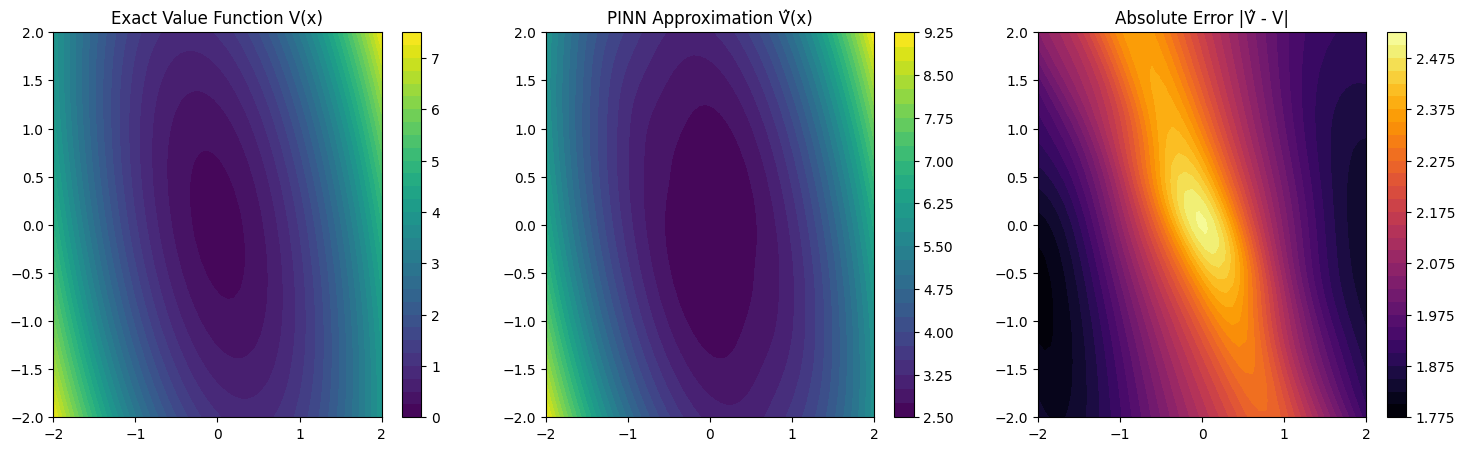

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are

# === Analytical solution ===
# CARE with discount rate
rho = 0.1
A_tilde = A.numpy() - (rho/2) * np.eye(A.shape[0])
P = solve_continuous_are(A_tilde, B.numpy(), Q.numpy(), R.numpy())
c = np.trace(P @ (G.numpy() @ G.numpy().T)) / rho

def V_exact(x):
    return x.T @ P @ x + c

def u_exact(x):
    return -(np.linalg.inv(R.numpy()) @ B.numpy().T @ (P @ x)).flatten()

# === PINN solution ===
def V_hat(x):
    x_t = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
    return model(x_t).item()

def u_hat(x):
    x_t = torch.tensor(x, dtype=torch.float32).unsqueeze(0).requires_grad_(True)
    V = model(x_t)
    gradV = autograd.grad(V.sum(), x_t, create_graph=False)[0]
    return (-(torch.inverse(R) @ B.T @ gradV.T)).detach().numpy().flatten()

# === Evaluation Grid ===
grid_x = np.linspace(-2, 2, 50)
grid_y = np.linspace(-2, 2, 50)
X, Y = np.meshgrid(grid_x, grid_y)

V_exact_vals = np.zeros_like(X)
V_pinn_vals = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x = np.array([X[i, j], Y[i, j]])
        V_exact_vals[i, j] = V_exact(x)
        V_pinn_vals[i, j] = V_hat(x)

# === Error metrics ===
abs_err = np.abs(V_pinn_vals - V_exact_vals)
rel_err = np.abs(V_pinn_vals / V_exact_vals - 1)

e1 = np.mean(abs_err)   # L1 norm (mean absolute error)
e2 = np.mean(rel_err)   # relative error

print("L1 absolute error (e1):", e1)
print("Relative error (e2):", e2)

# === Plots ===
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

cs0 = axs[0].contourf(X, Y, V_exact_vals, levels=30, cmap="viridis")
fig.colorbar(cs0, ax=axs[0])
axs[0].set_title("Exact Value Function V(x)")

cs1 = axs[1].contourf(X, Y, V_pinn_vals, levels=30, cmap="viridis")
fig.colorbar(cs1, ax=axs[1])
axs[1].set_title("PINN Approximation V̂(x)")

cs2 = axs[2].contourf(X, Y, abs_err, levels=30, cmap="inferno")
fig.colorbar(cs2, ax=axs[2])
axs[2].set_title("Absolute Error |V̂ - V|")

plt.show()
